# **Importing the data**

<p style="font-size: 18px;">Added dataset in Kaggle and imported it to the notebook.</p>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

In [2]:
import os
import PIL
# checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

DIR = "/kaggle/input/chest-xray-masks-and-labels/data/"


lung_image_paths = glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths = glob(os.path.join(DIR,"Lung Segmentation/masks/*.png"))

related_paths = defaultdict(list)

#In our dataset all masks doesn't contain mask , so here we are trying to
#segregate the x_rays alongside thier mask.

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)

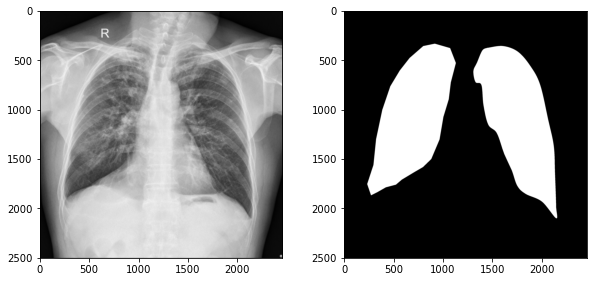

In [3]:
#plottin some example X-rays and masks
xray_num = 5
img_path = paths_df["image_path"][xray_num]
mask_path = paths_df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray")

# **Preprocessing Task**

<p style="font-size: 18px;">Here I have done some slight preprocessing task and splitting up of our dataset for train and test purposes.</p>

In [4]:
from tqdm import tqdm
import cv2
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
  
    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (224,224), color_mode = "gray")


100%|██████████| 704/704 [00:52<00:00, 13.53it/s]


In [5]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(img_array, mask_array, test_size = 0.2, random_state= 42)

img_side_size = 224
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size, 1)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size, 1)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size, 1)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size, 1)

# **Defining the model**

<p style="font-size: 18px;">Here we have defined the whole model and dice coefficient function that would be used further during our model testing.
We have also used early stopping to protect our model from overfitting.</p>

In [6]:
### U-net 

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(224,224,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
   
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [7]:
EPOCHS = 10
model = unet(input_size=(224,224,1))
model.compile(optimizer=Adam(lr=5*1e-4), loss="binary_crossentropy", \
                  metrics=['binary_accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [8]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(x = img_train, 
                    y = mask_train, 
                    validation_data = (img_test, mask_test), 
                    epochs = 30, 
                    batch_size = 16,
                   callbacks = [earlystopping])

Epoch 1/30
36/36 [==============================] - 5s 149ms/step - loss: 0.5703 - binary_accuracy: 0.7443 - val_loss: 0.5131 - val_binary_accuracy: 0.7454
Epoch 2/30
36/36 [==============================] - 4s 113ms/step - loss: 0.4893 - binary_accuracy: 0.7463 - val_loss: 0.4897 - val_binary_accuracy: 0.7454
Epoch 3/30
36/36 [==============================] - 4s 113ms/step - loss: 0.4438 - binary_accuracy: 0.7463 - val_loss: 0.4003 - val_binary_accuracy: 0.7454
Epoch 4/30
36/36 [==============================] - 4s 113ms/step - loss: 0.3508 - binary_accuracy: 0.7863 - val_loss: 0.2892 - val_binary_accuracy: 0.8951
Epoch 5/30
36/36 [==============================] - 4s 113ms/step - loss: 0.2939 - binary_accuracy: 0.8874 - val_loss: 0.2336 - val_binary_accuracy: 0.9289
Epoch 6/30
36/36 [==============================] - 4s 113ms/step - loss: 0.1824 - binary_accuracy: 0.9350 - val_loss: 0.1477 - val_binary_accuracy: 0.9447
Epoch 7/30
36/36 [==============================] - 4s 113ms/ste

<p style="font-size: 18px;">Writting down a test function which we would use to test what kind of masks our model is predicting on the test X-rays. Also we are showing five plots containing original mask , predicted mask, overalp , original chest X-ray and segmented chest X-ray.</p>

0.912556043761572

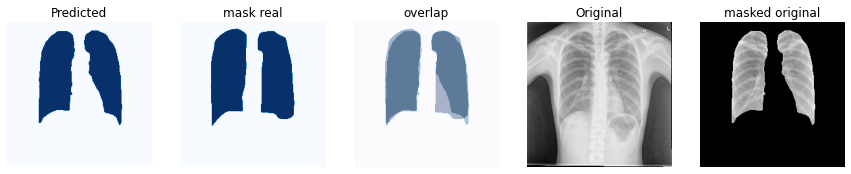

In [9]:
#test function for checking our u-net model
def test_on_image(model, img_array, img_num, img_side_size = 128):
    
    pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    fig = plt.figure(figsize = (15,10))
    
    plt.subplot(1,5,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("Predicted")
    plt.axis("off")
    
    plt.subplot(1,5,2)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("mask real");
    plt.axis("off")
    
    plt.subplot(1,5,3)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
    plt.title("overlap")
    plt.axis("off")
    
    plt.subplot(1,5,4)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap = "gray")
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1,5,5)
    plt.imshow((img_array[img_num].reshape(img_side_size, img_side_size))*(pred.reshape(img_side_size, img_side_size)), cmap = "gray")
    plt.title("masked original")
    plt.axis("off")
    return pred

def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

IMG_NUM = 3 
prediction = test_on_image(model, img_array = img_test, img_num = IMG_NUM, img_side_size = 224)
dice_coef_test(y_true = mask_test[IMG_NUM], y_pred = prediction)

In [10]:
model.save("unet.h5")

<p style="font-size: 18px;">Plotting metrics showing how the model evolved. It shows how our model was able to better up on both binary cross entropy and Dice coefficient.</p>

<p style="font-size: 18px;">It is a graphical representation hence it becomes more easy to understand the progress of our model.</p>

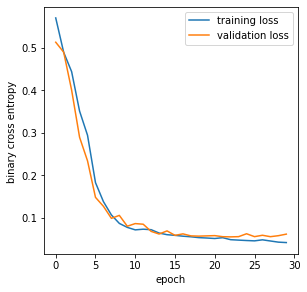

In [11]:
#plotting the history of our model's learning.
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("binary cross entropy ")

get_metrics(history = history)

<p style="font-size:18px;">To know and visualize where our convultion fiters are focussing , we have plotted some of our convultion filters. </p>

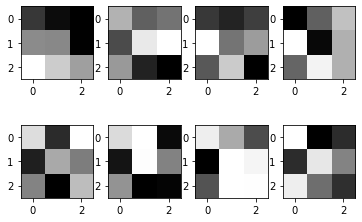

In [12]:
#taking filters and biases of first convultion layer.
filters, biases = history.model.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

show_n_filters = 8
n_rows = 2
for i in range(show_n_filters):
    plt.subplot(n_rows,show_n_filters/n_rows,i+1)
    plt.imshow(filters[:,:,:,i].reshape(filters[:,:,:,i].shape[0], filters[:,:,:,i].shape[1]), cmap = "gray")


In [13]:

filters, biases = history.model.layers[4].get_weights()
filters.shape

(3, 3, 32, 64)

In [14]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:30]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

In [15]:
#testing on of our chest x-ray images
activations = activation_model.predict(img_array[1].reshape(1,224,224,1)) 

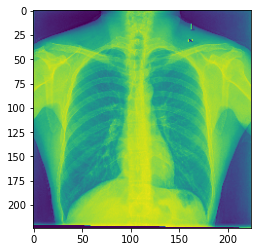

In [16]:
num = 0
size = 224
plt.imshow(activations[num].reshape(size, size))

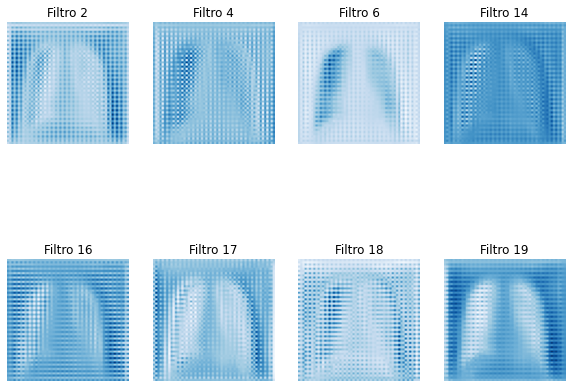

In [17]:
#plotting filters for different convulution layers.
num_activ = 20
num_filters = 8
nrows = 2
plt.figure(figsize = (10,8))
filter_conv = 0
i = 0
while i < num_filters:
    try:
        if activations[num_activ][:,:,:,filter_conv].sum()> 5:
            plt.subplot(n_rows,show_n_filters/n_rows,i+1)
            plt.imshow(activations[num_activ][:,:,:,filter_conv].reshape(activations[num_activ].shape[1], activations[num_activ].shape[2]), cmap = "Blues")
            plt.title("Filtro {}".format(filter_conv))
            plt.axis("off")
            i+=1
        filter_conv += 1
    except:
        pass

In [18]:
activations[2].shape

(1, 224, 224, 32)

<p style="font-size: 18px;"> Finally Testing our model on test images and plotting our final Dice similarity coefficient across all testing images.</p>

 14%|█▍        | 20/141 [00:02<00:16,  7.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
100%|██████████| 141/141 [00:19<00:00,  7.14it/s]


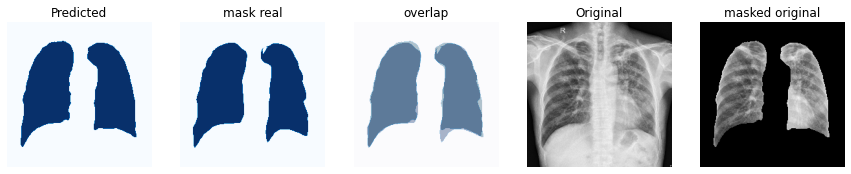

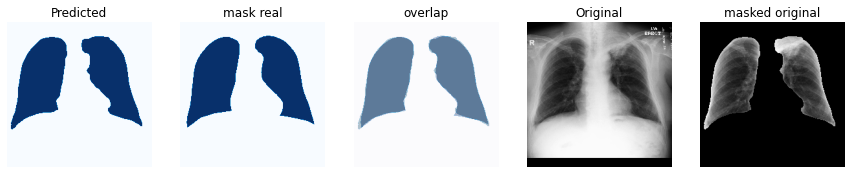

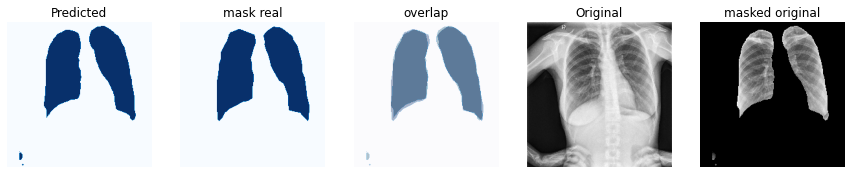

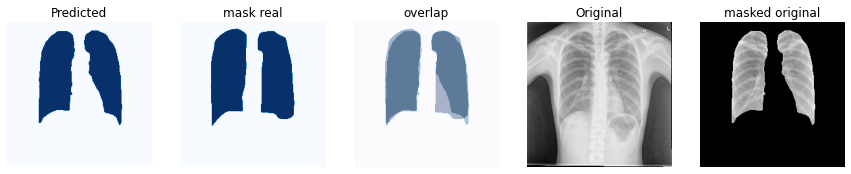

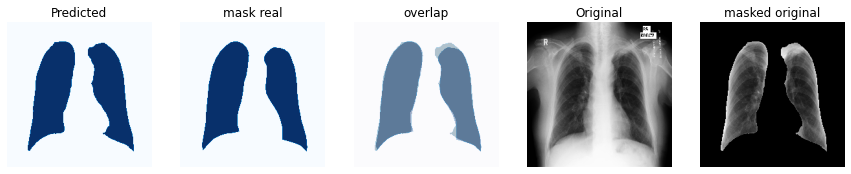

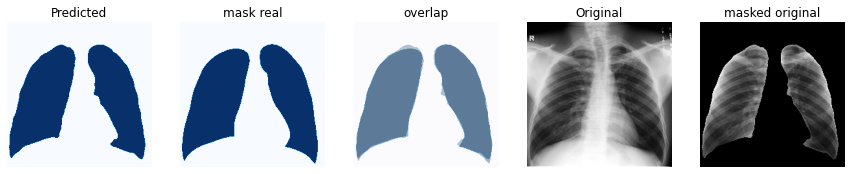

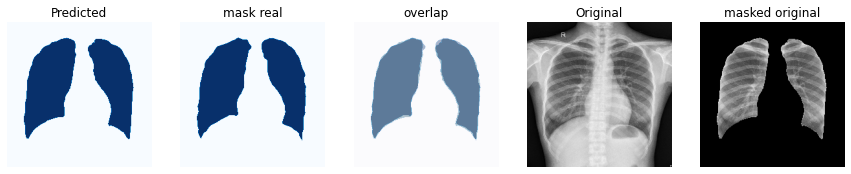

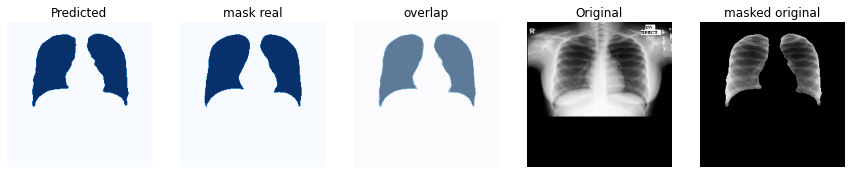

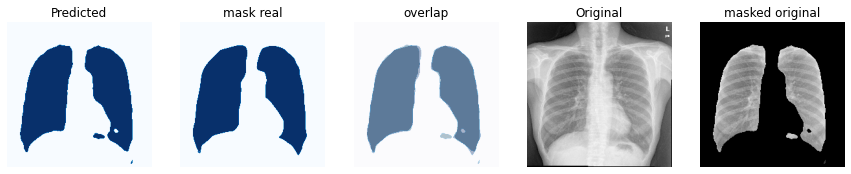

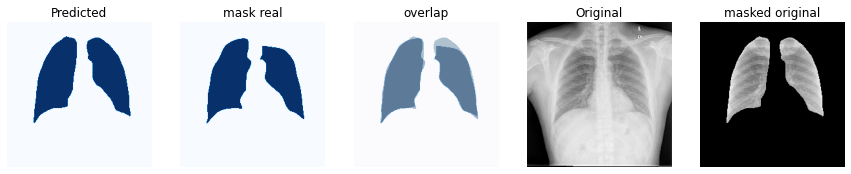

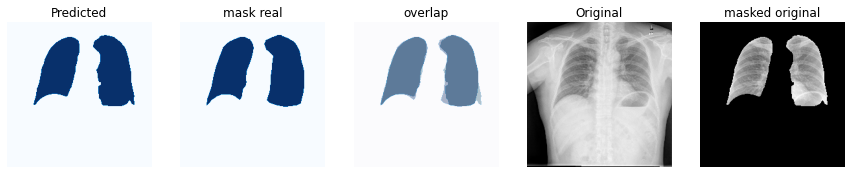

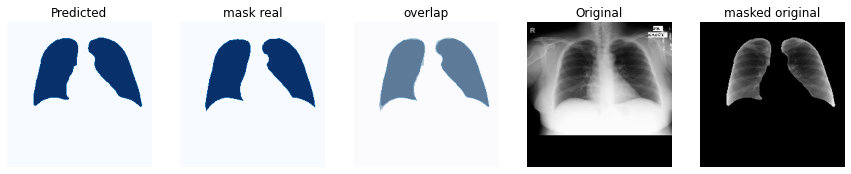

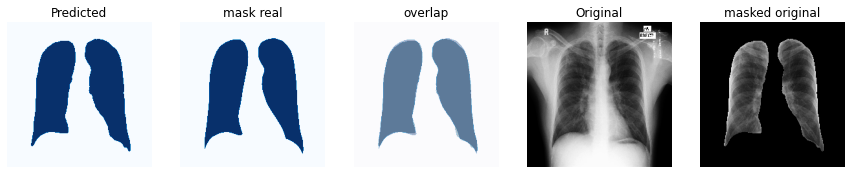

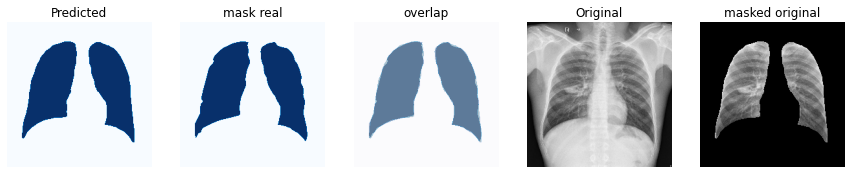

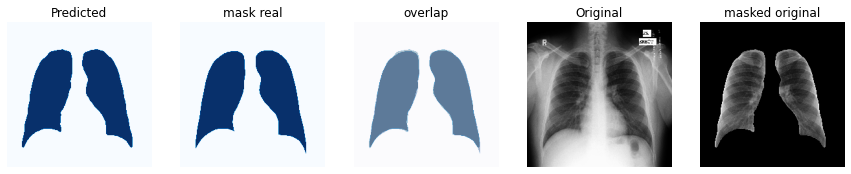

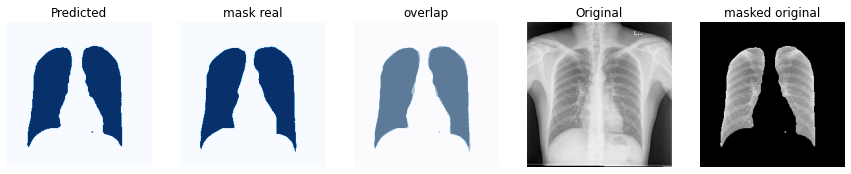

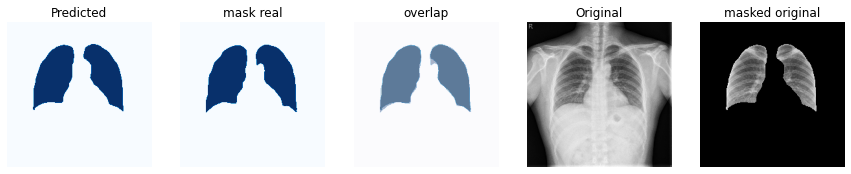

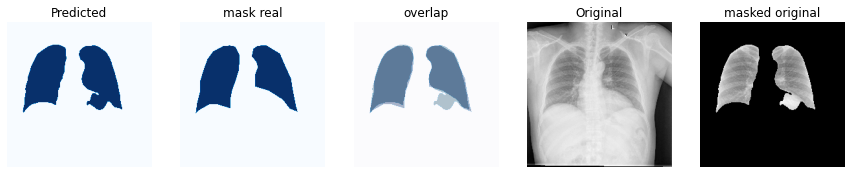

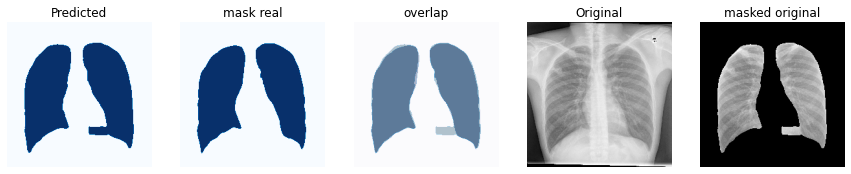

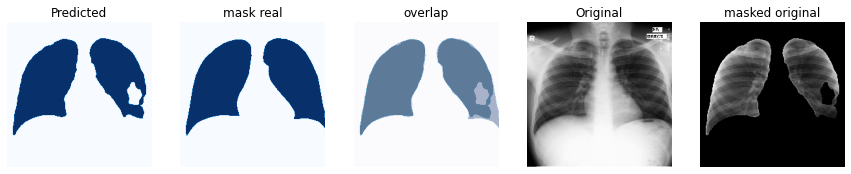

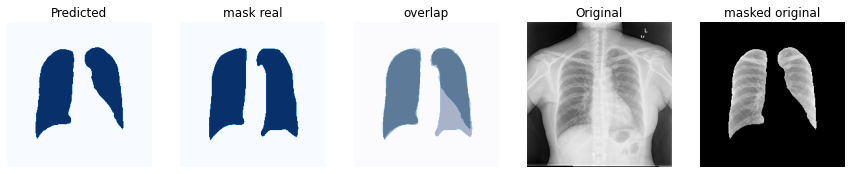

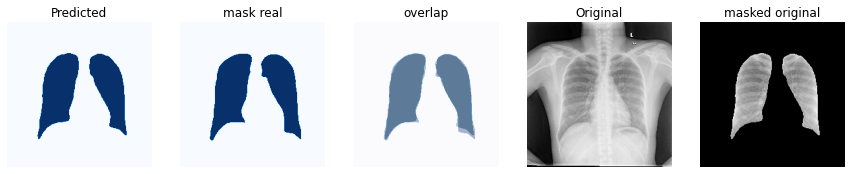

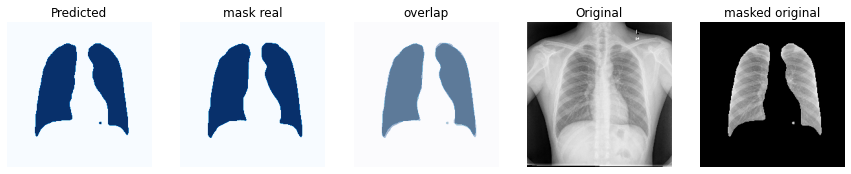

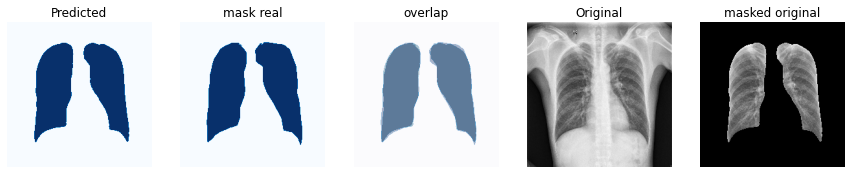

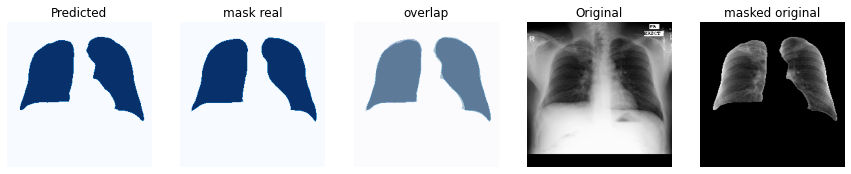

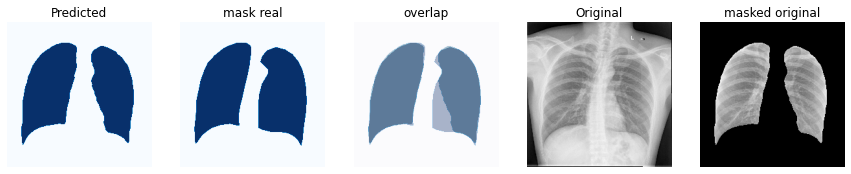

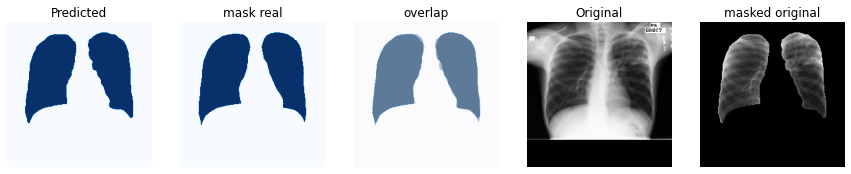

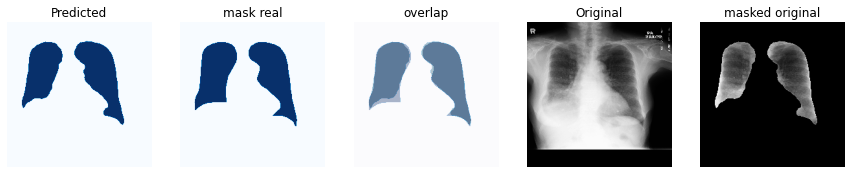

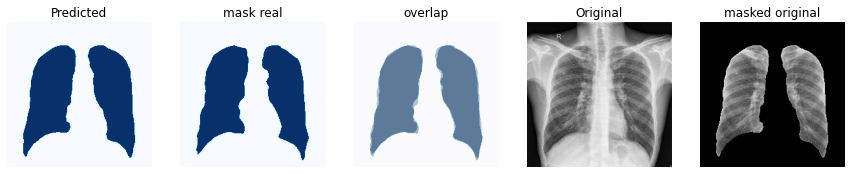

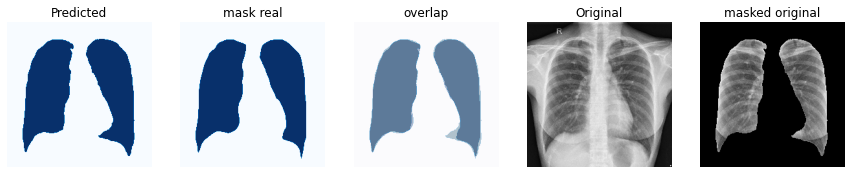

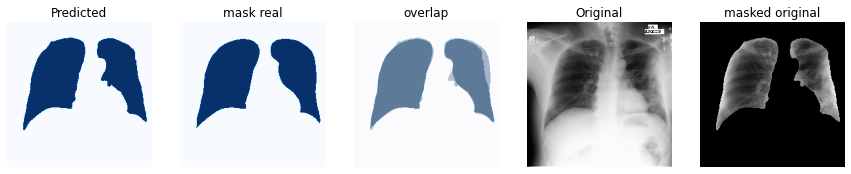

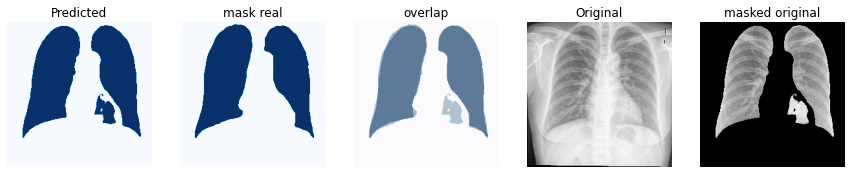

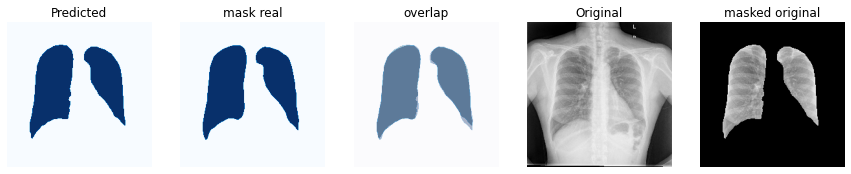

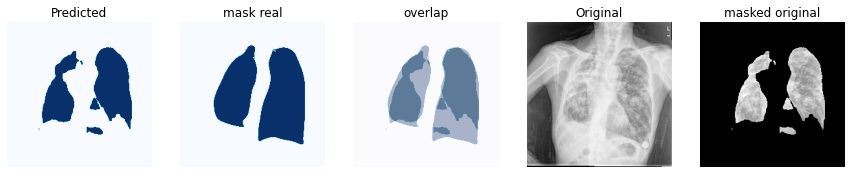

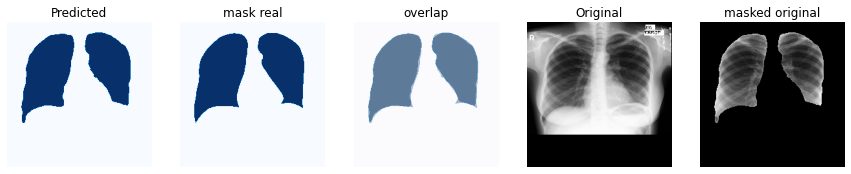

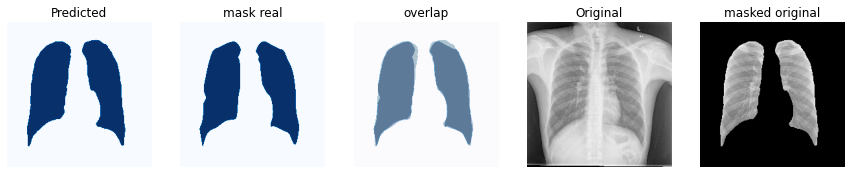

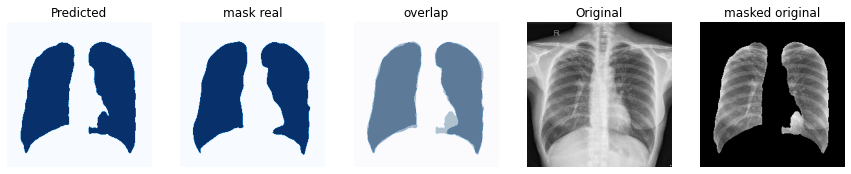

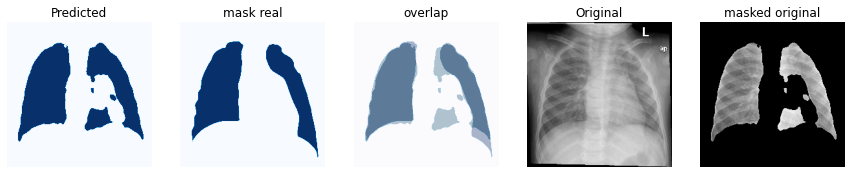

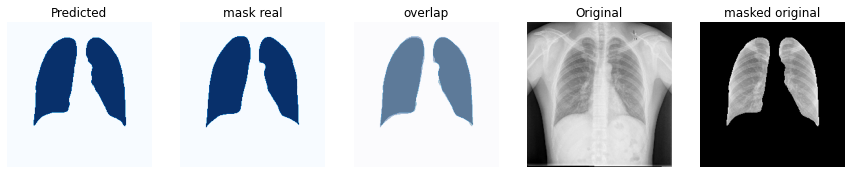

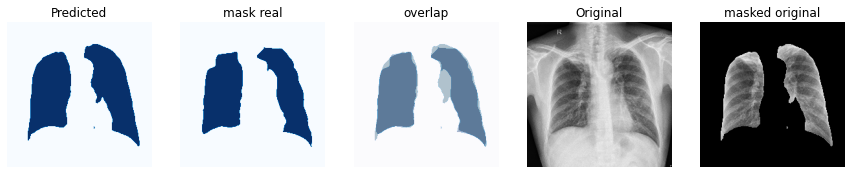

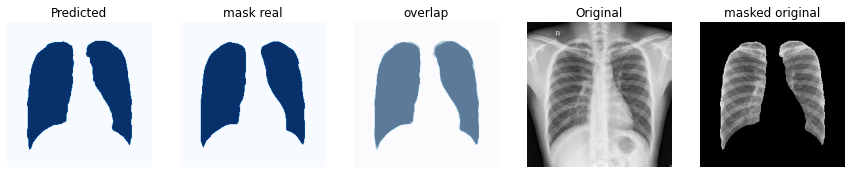

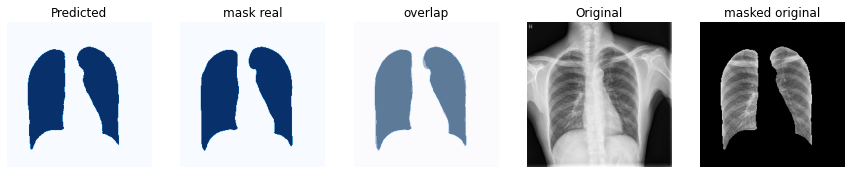

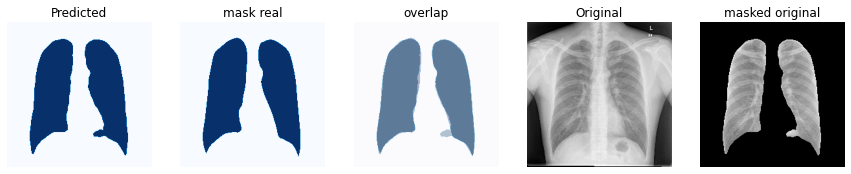

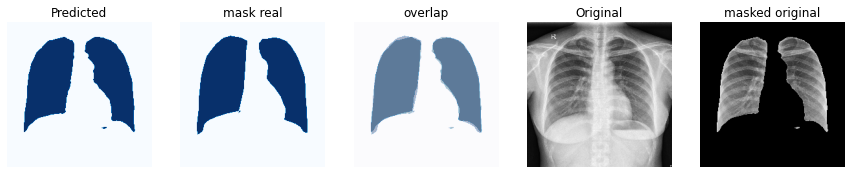

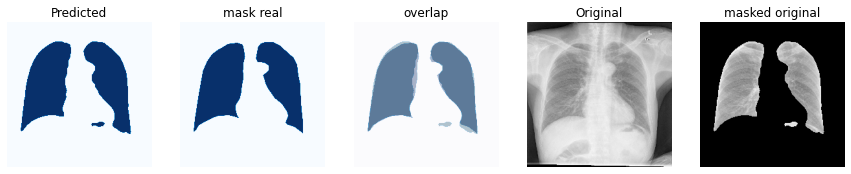

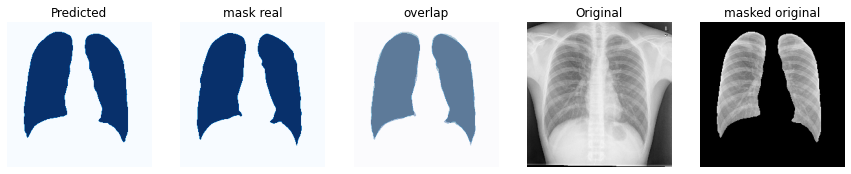

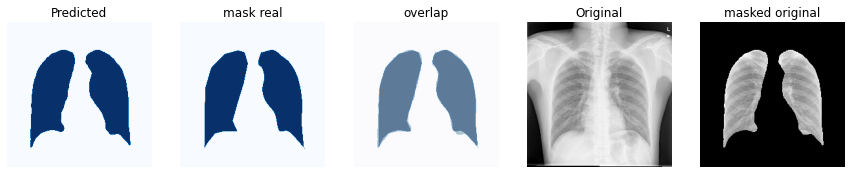

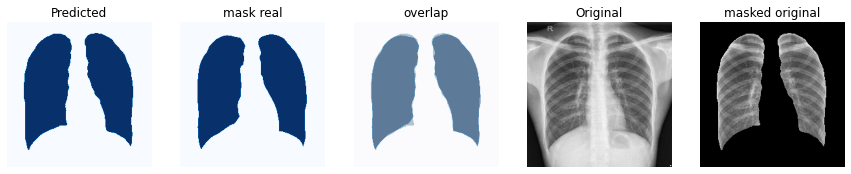

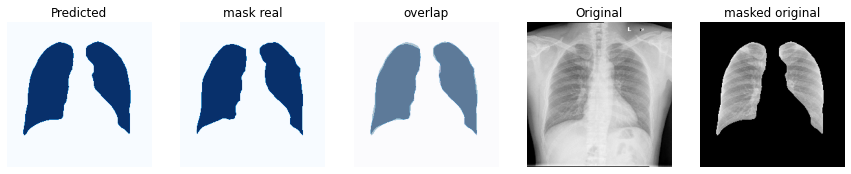

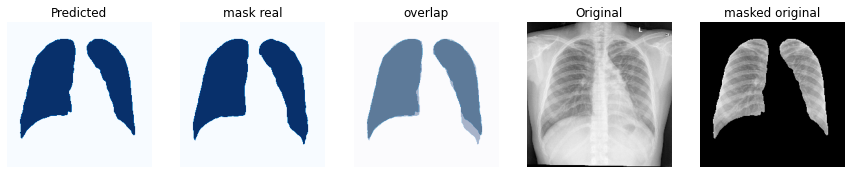

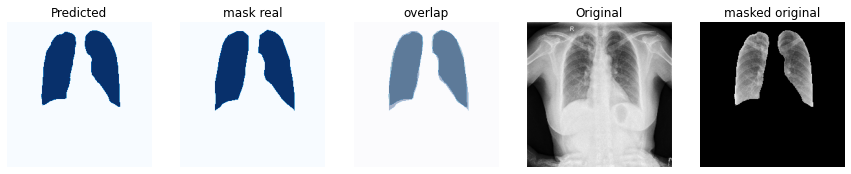

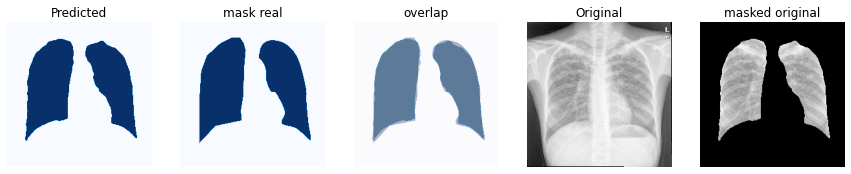

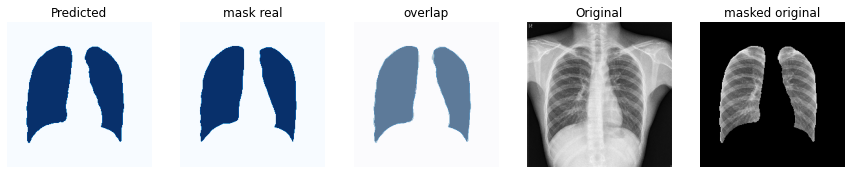

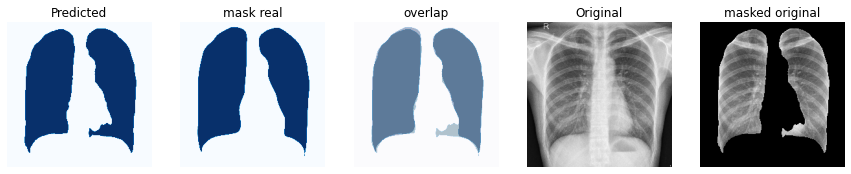

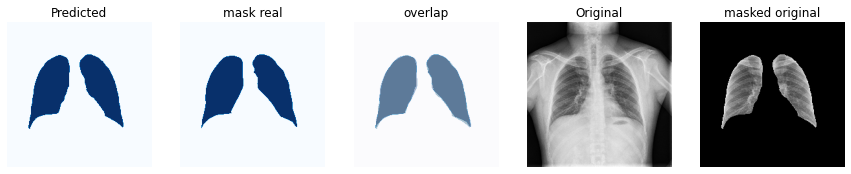

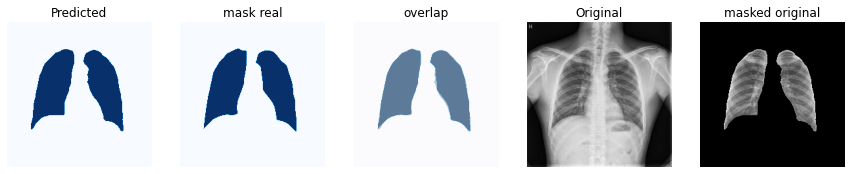

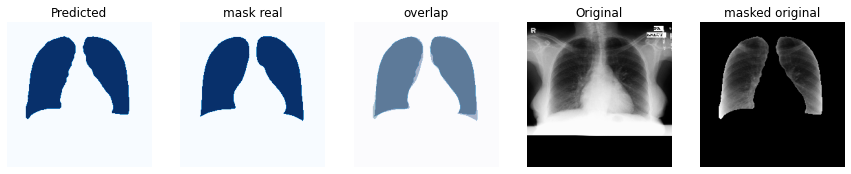

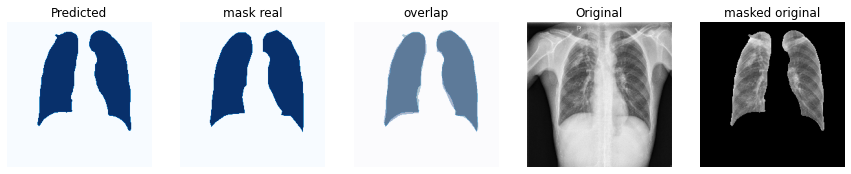

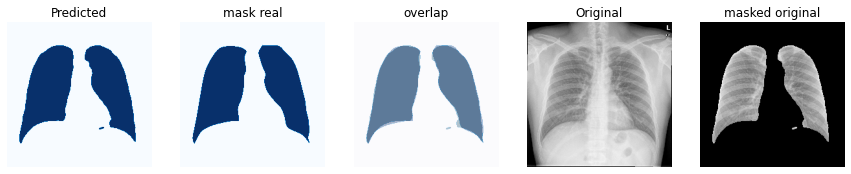

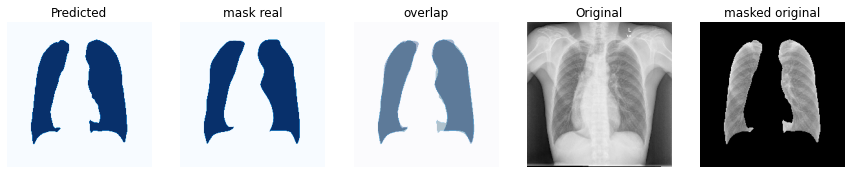

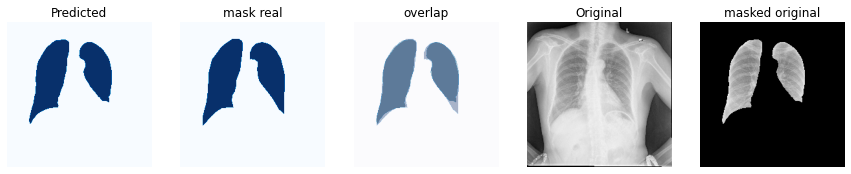

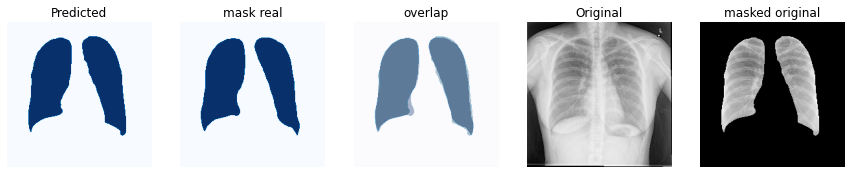

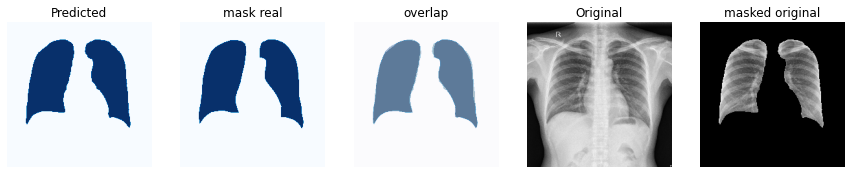

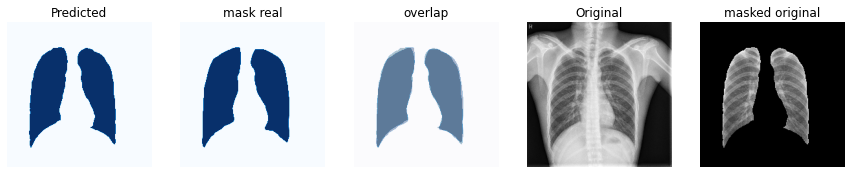

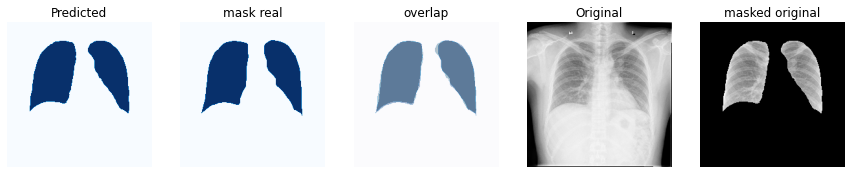

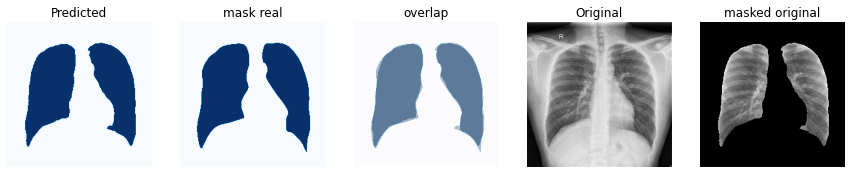

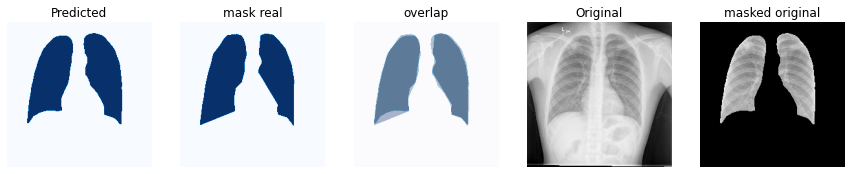

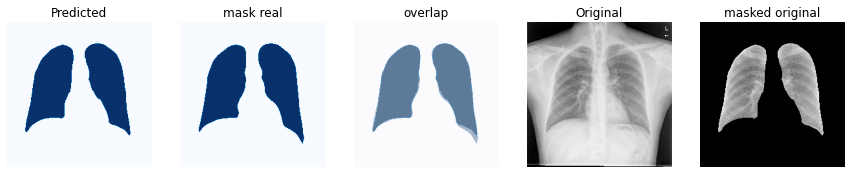

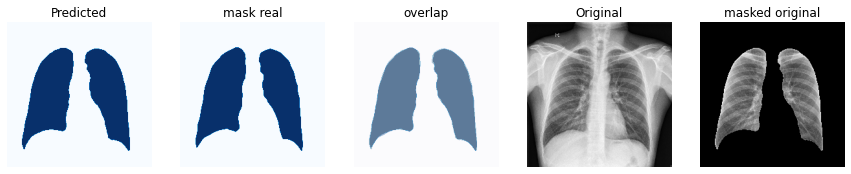

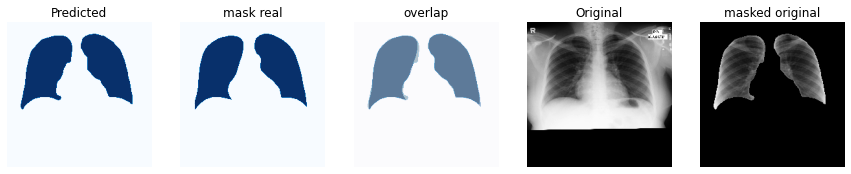

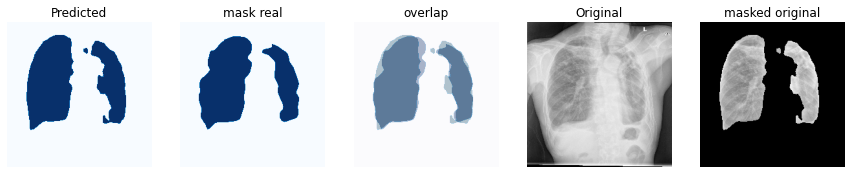

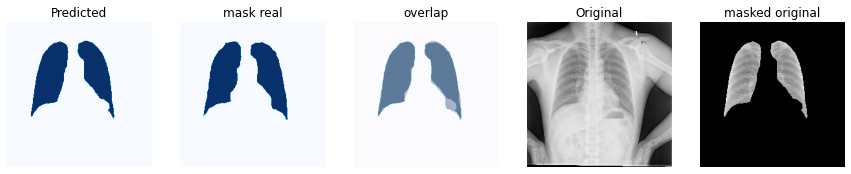

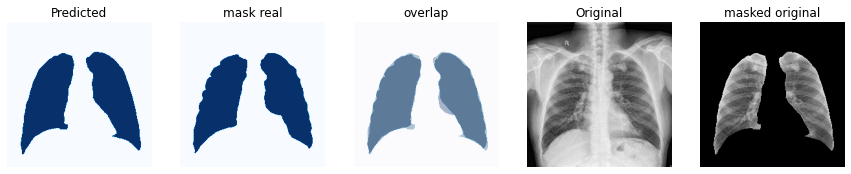

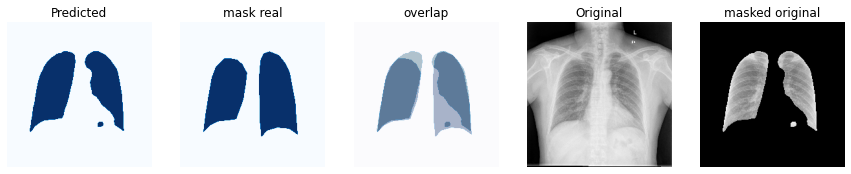

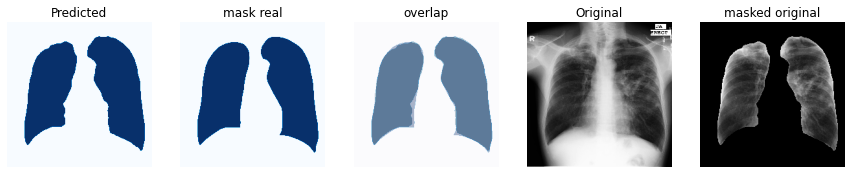

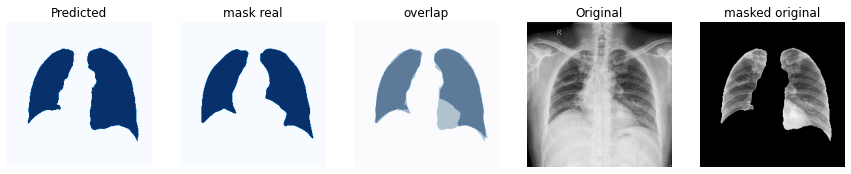

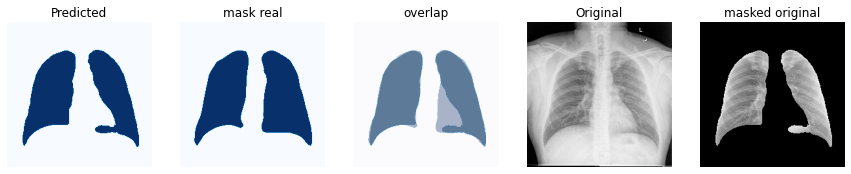

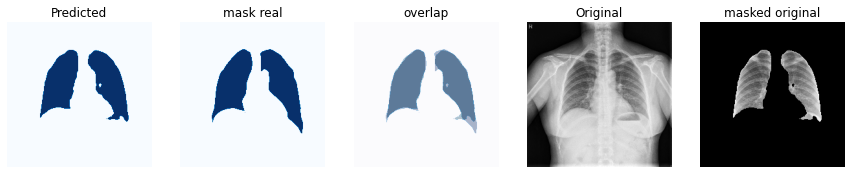

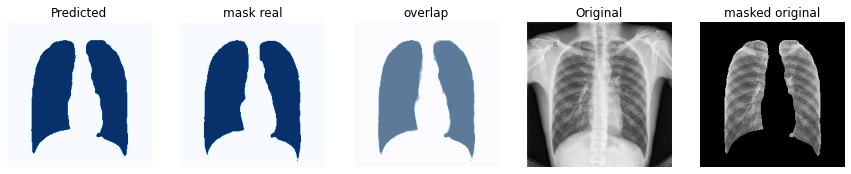

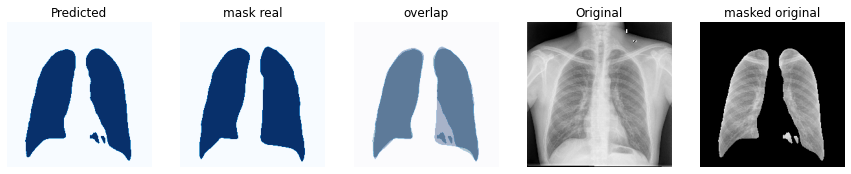

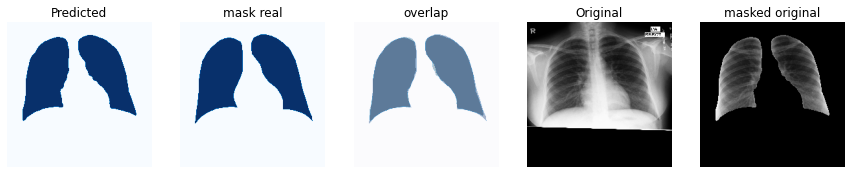

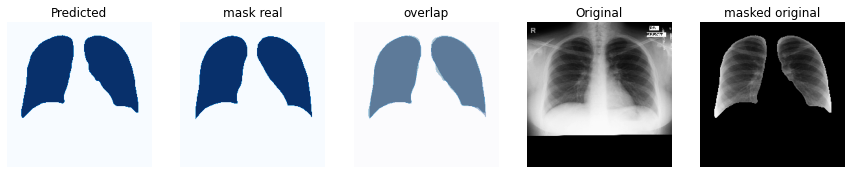

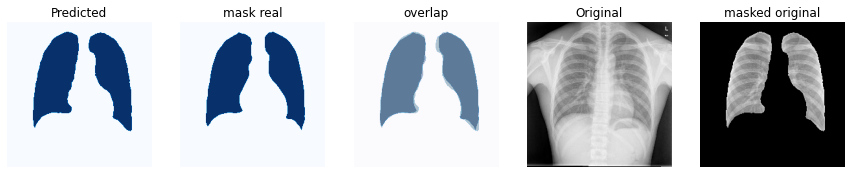

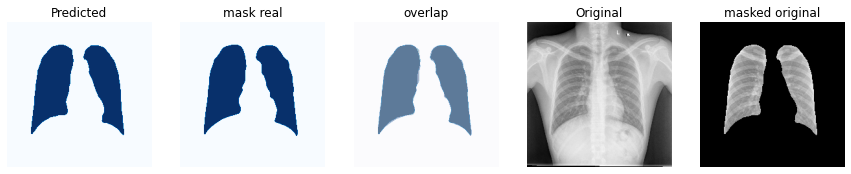

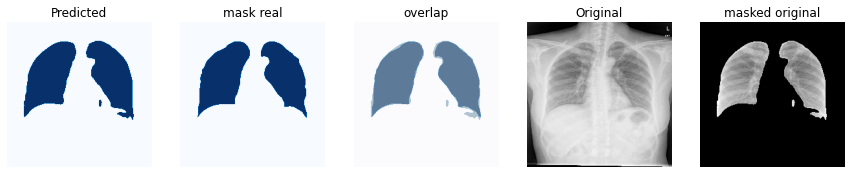

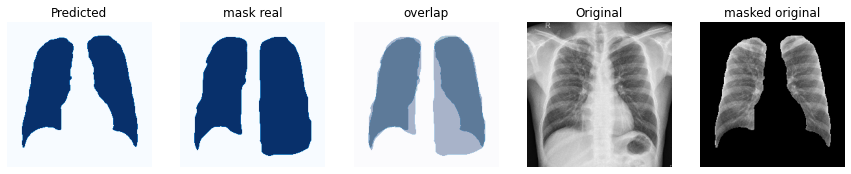

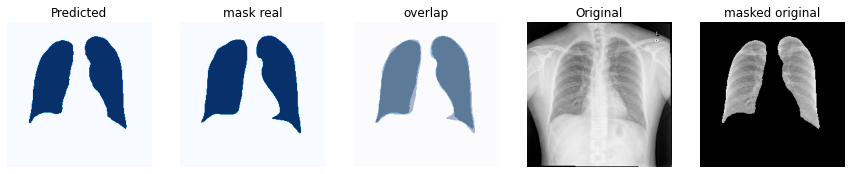

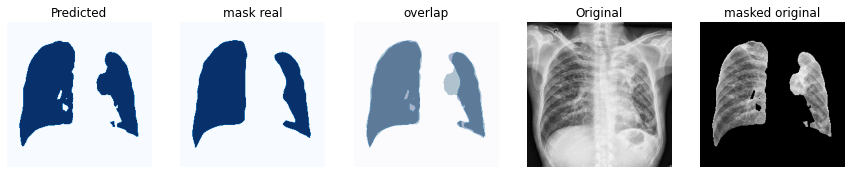

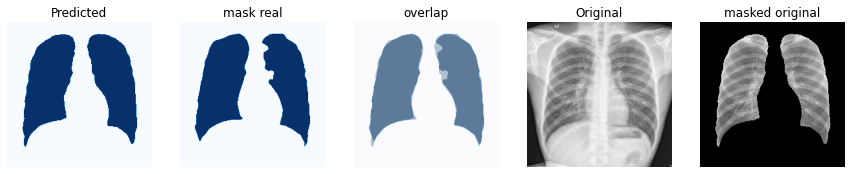

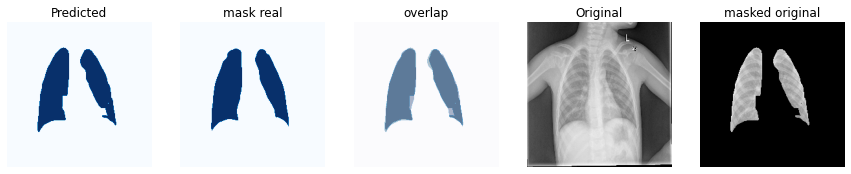

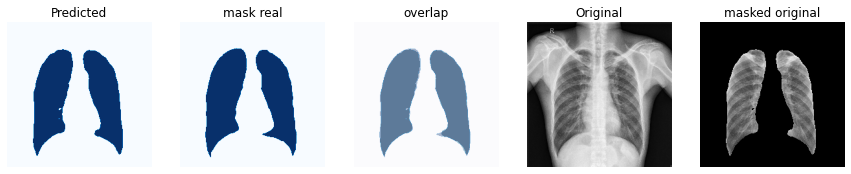

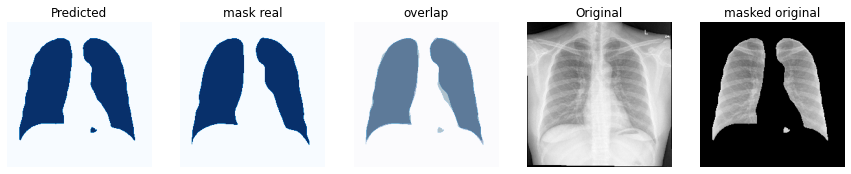

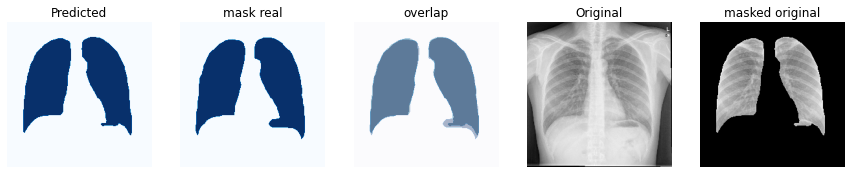

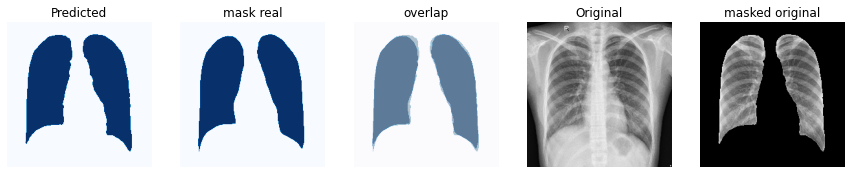

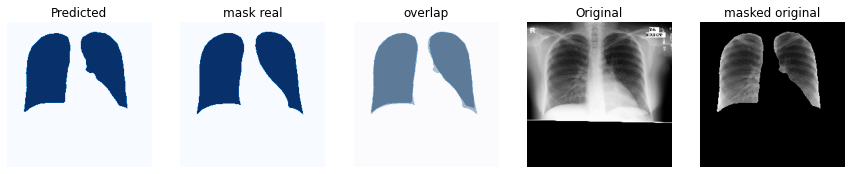

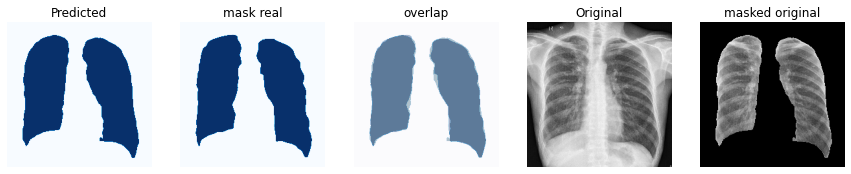

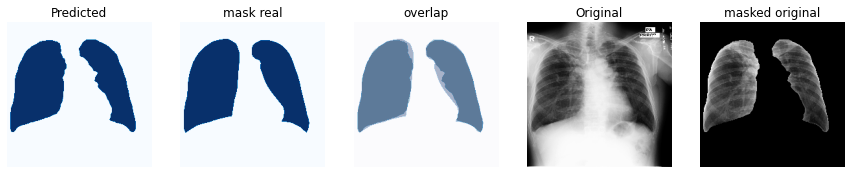

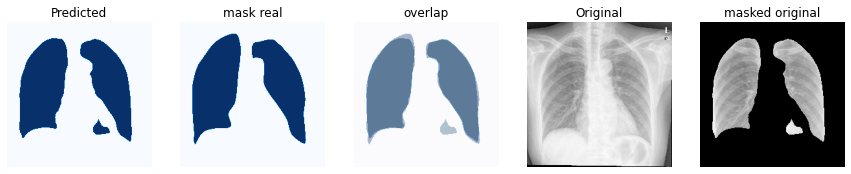

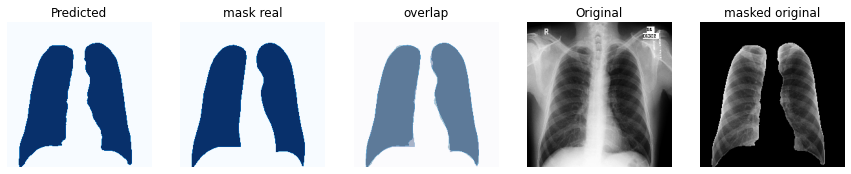

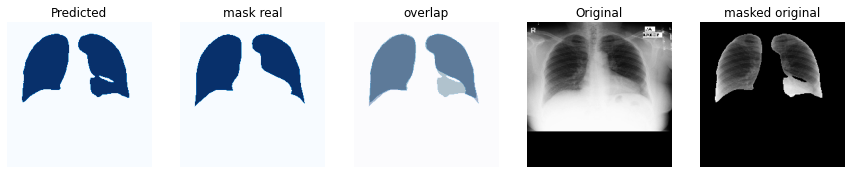

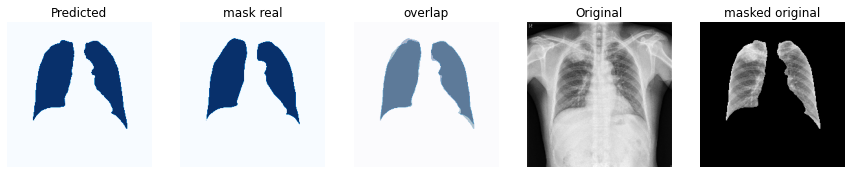

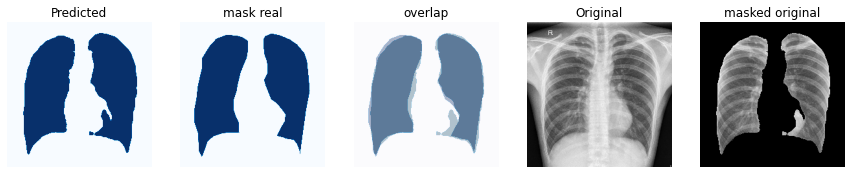

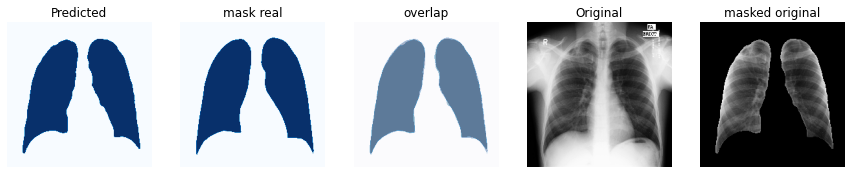

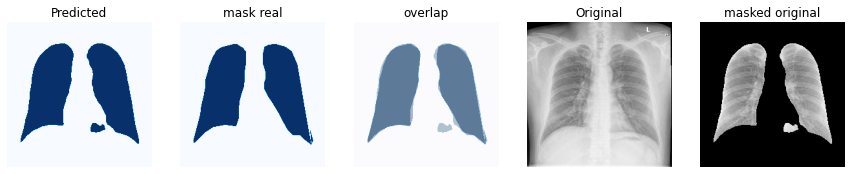

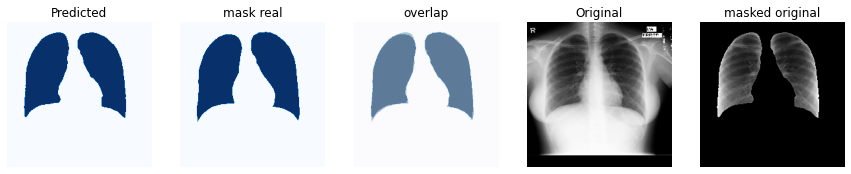

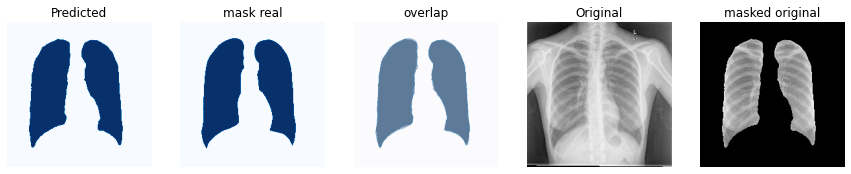

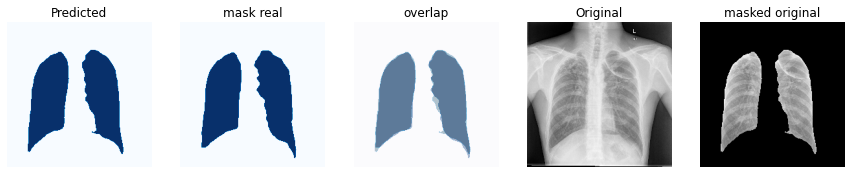

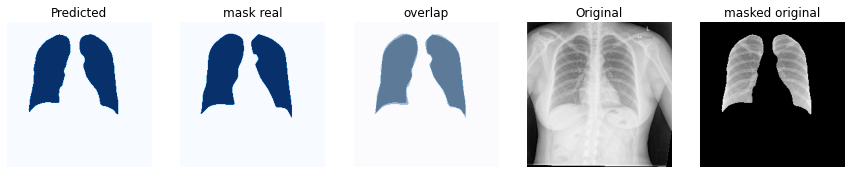

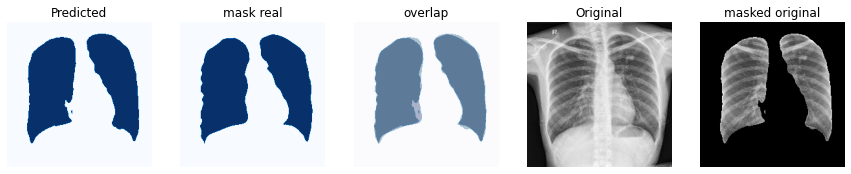

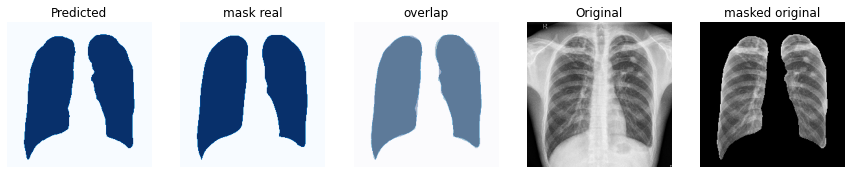

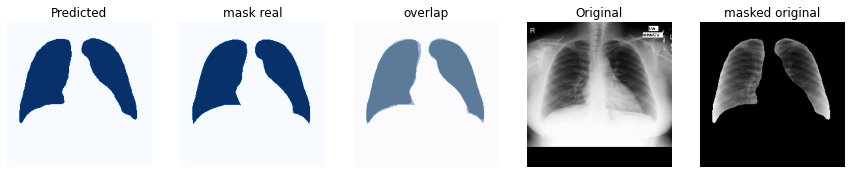

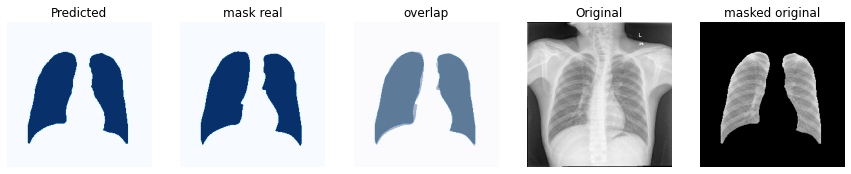

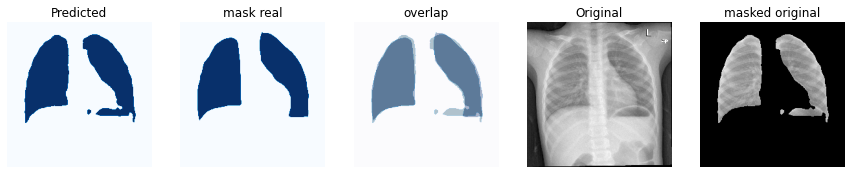

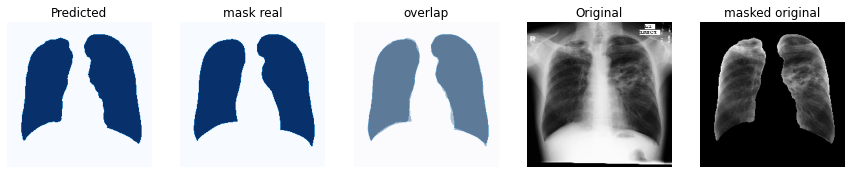

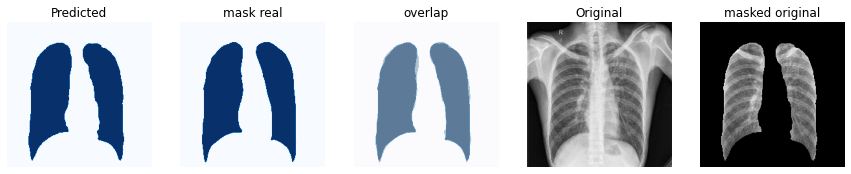

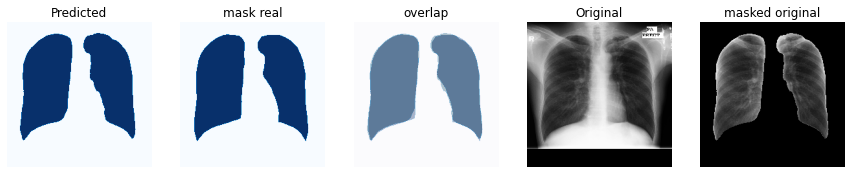

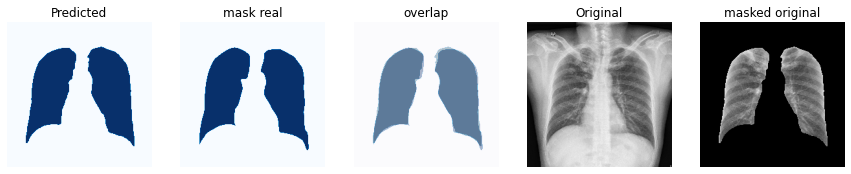

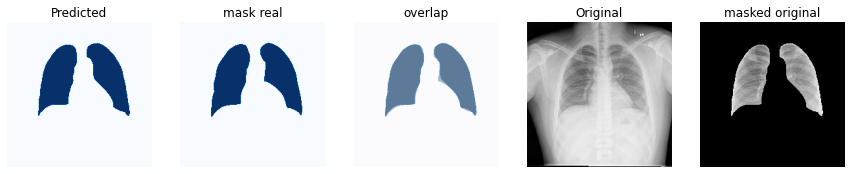

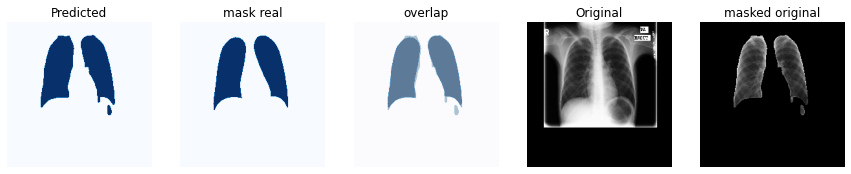

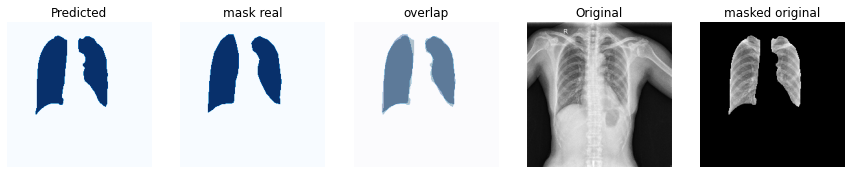

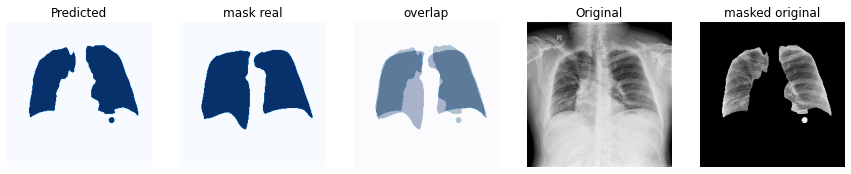

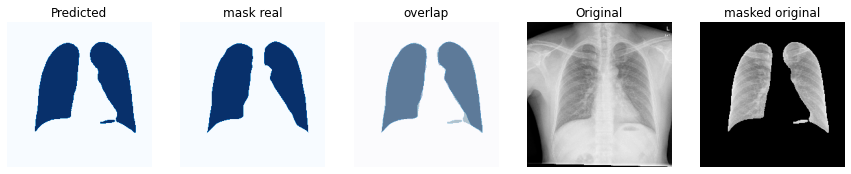

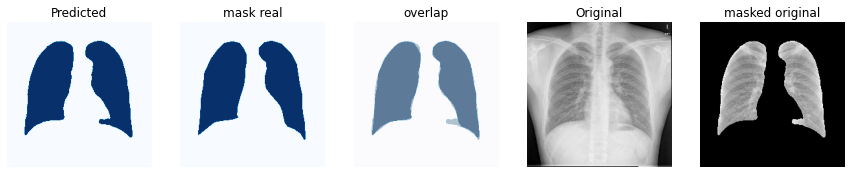

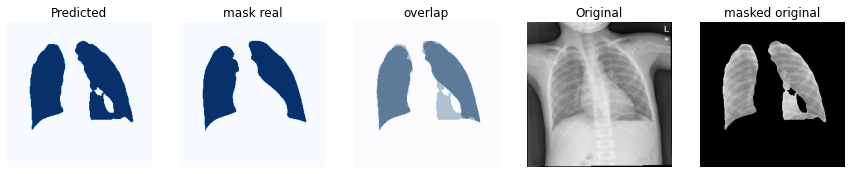

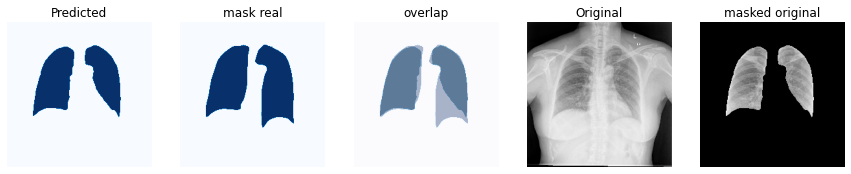

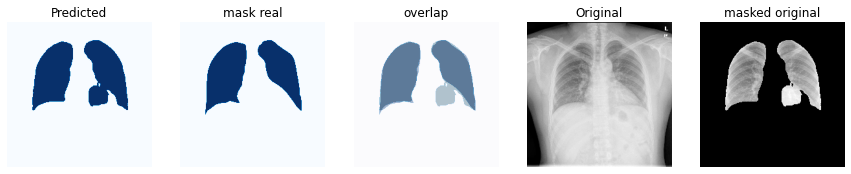

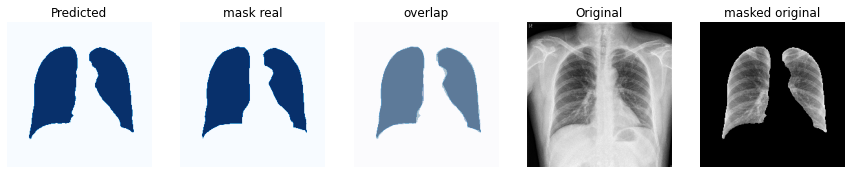

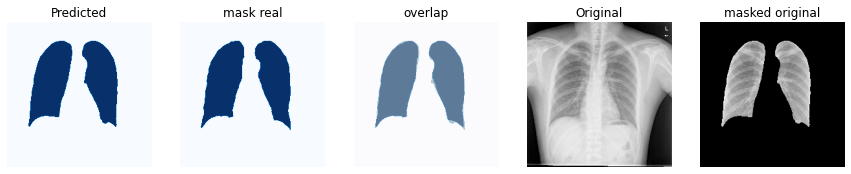

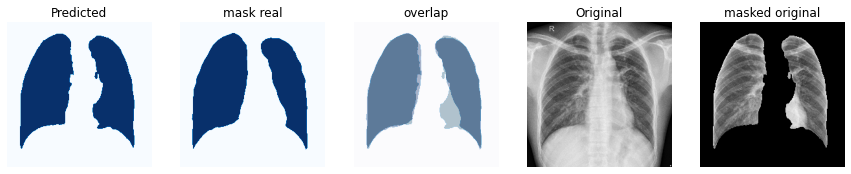

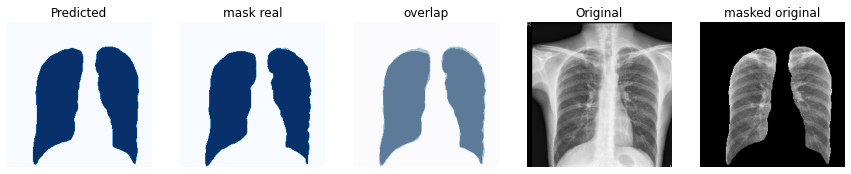

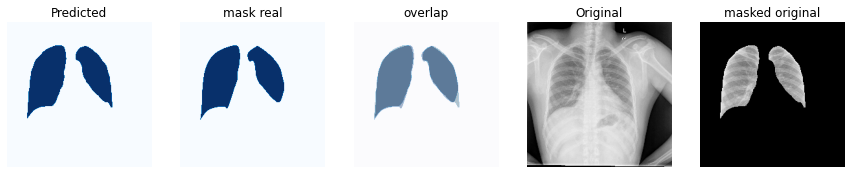

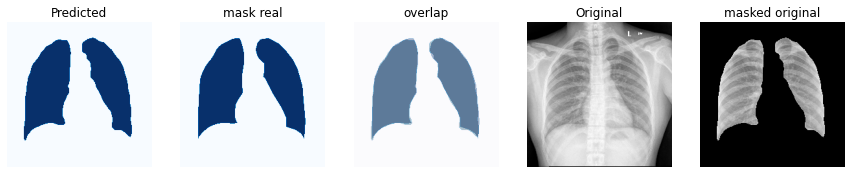

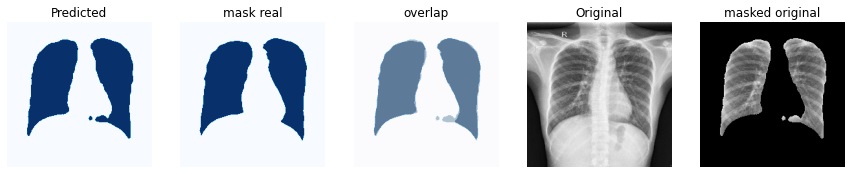

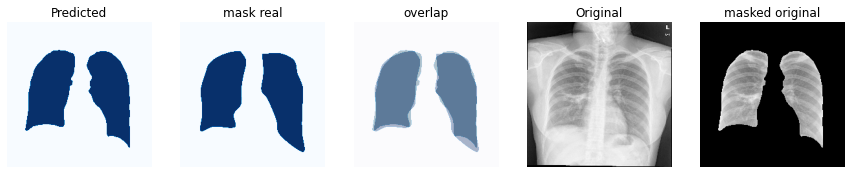

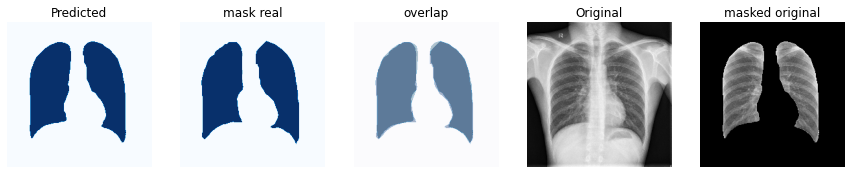

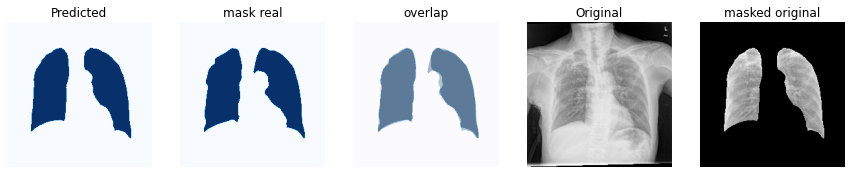

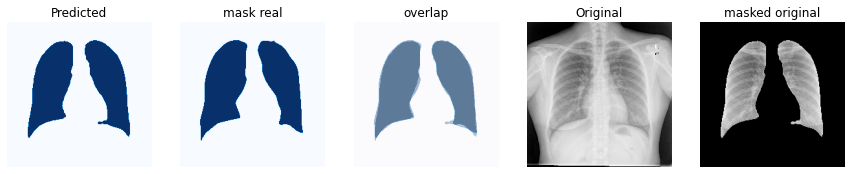

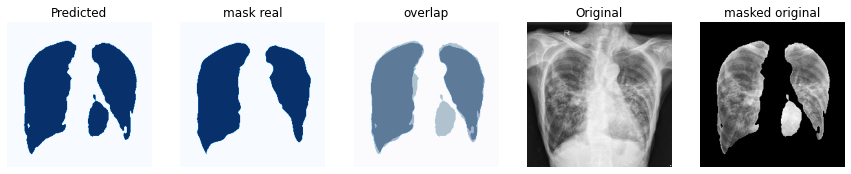

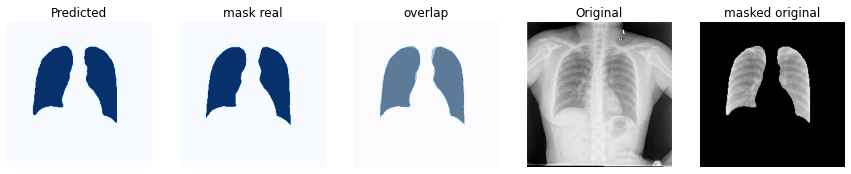

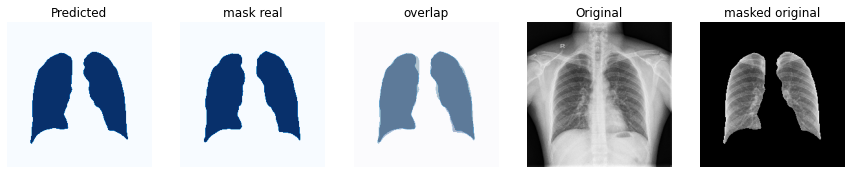

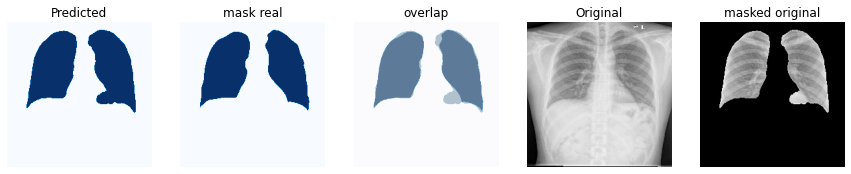

In [19]:
#listing down DSC value for each testing x_ray and finally plotted it.
dice_coefs = list()
for i in tqdm(range(len(img_test))):
    prediction = test_on_image(model, img_array = img_test, img_num = i, img_side_size = 224)
    dice = dice_coef_test(y_true = mask_test[i], y_pred = prediction)
    dice_coefs.append(dice)

0.9677086395359761


Text(0, 0.5, 'Number of Occurences')

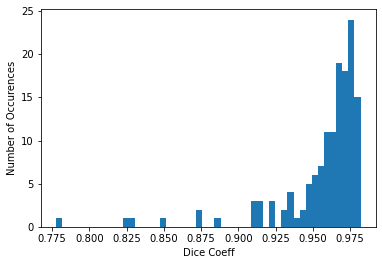

In [20]:
plt.hist(np.array(dice_coefs), bins = 50)
print(np.median(np.array(dice_coefs)))
plt.xlabel("Dice Coeff")
plt.ylabel("Number of Occurences")